In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


BASE_DIR = '/kaggle/input/utkface-new/UTKFace'
IMG_SIZE = (128, 128)
BATCH_SIZE = 128
EPOCHS = 100
MAX_AGE = 116.0

2025-08-05 14:43:11.973528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754404992.164537      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754404992.220888      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data():
    images, ages = [], []
    for file in tqdm(os.listdir(BASE_DIR)):
        temp = file.split('_')
        if len(temp) >= 1 and temp[0].isdigit():
            ages.append(int(temp[0]) / MAX_AGE)  
            img_path = os.path.join(BASE_DIR, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)
    
    images = np.array(images)
    ages = np.array(ages)
    return images, ages

In [3]:
def get_data_augmentation():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.1),
    ])

In [4]:
#Gradual decay of learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    return initial_lr * (1.0 / (1.0 + 0.02 * epoch))

In [5]:
def build_model():
    inputs = Input(shape=(128, 128, 1))
    x = get_data_augmentation()(inputs)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x) 
    
    age_output = Dense(1, name='age')(x)  
    
    model = Model(inputs=inputs, outputs=age_output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error', 
        metrics=['mae']
    )
    model.summary()
    return model

In [6]:
def check_data_distribution(X_train, y_train_age, X_val, y_val_age, X_test, y_test_age):
    print(f"Training set: {len(X_train)} samples, Age mean: {np.mean(y_train_age) * MAX_AGE:.2f}")
    print(f"Validation set: {len(X_val)} samples, Age mean: {np.mean(y_val_age) * MAX_AGE:.2f}")
    print(f"Test set: {len(X_test)} samples, Age mean: {np.mean(y_test_age) * MAX_AGE:.2f}")

100%|██████████| 23708/23708 [00:26<00:00, 909.61it/s] 


Training set: 16002 samples, Age mean: 33.43
Validation set: 5335 samples, Age mean: 32.99
Test set: 2371 samples, Age mean: 33.18


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,617,345 (17.61 MB)

 Trainable params: 4,616,385 (17.61 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 30.5226 - mae: 2.5039
Epoch 1: val_mae improved from inf to 0.32095, saving model to /kaggle/working/agetask4.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 30.1748 - mae: 2.4826 - val_loss: 0.2331 - val_mae: 0.3210 - learning_rate: 0.0010
Epoch 2/100
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1697 - mae: 0.2079
Epoch 2: val_mae did not improve from 0.32095
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.1695 - mae: 0.2076 - val_loss: 0.3062 - val_mae: 0.4007 - learning_rate: 9.8039e-04
Epoch 3/100
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1371 - mae: 0.1537
Epoch 3: val_mae improved from 0.32095 to 0.26648, saving model to /kaggle/working/agetask4.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - loss: 0.1371 - mae: 0.1536 - val_loss: 0.2065 - val_mae: 0.2665 - learning_rate: 9.6154e-04
Epoch 4/100
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1268 - mae: 0.1352
Epoc

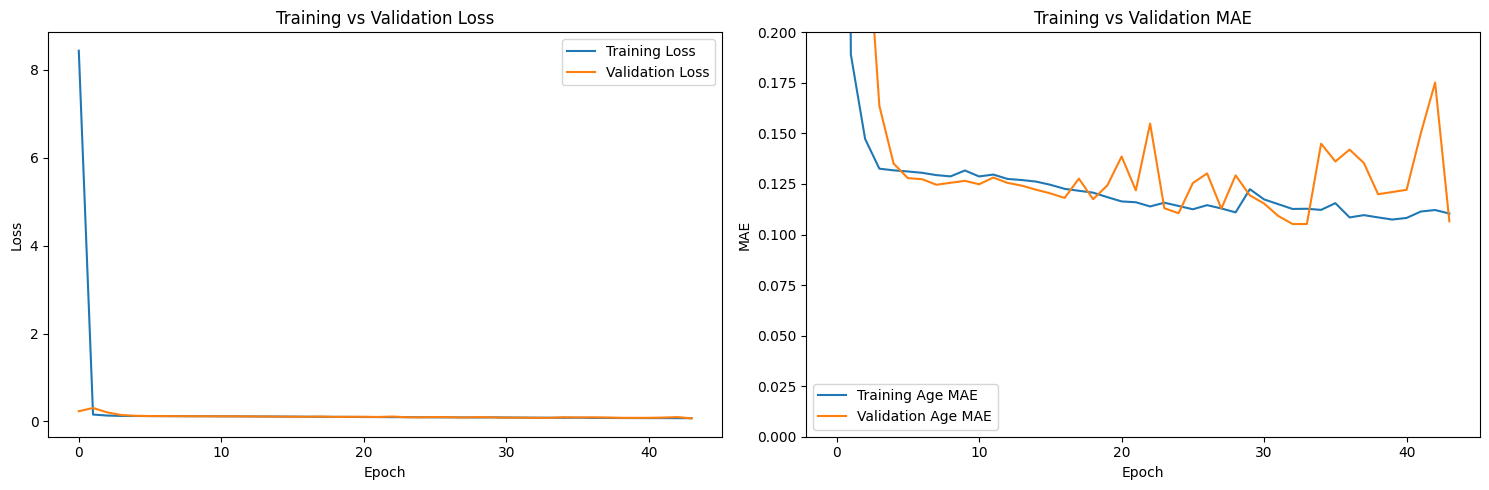

In [10]:
images, ages = load_data()
X_temp, X_test, y_temp_age, y_test_age = train_test_split(
    images, ages, test_size=0.1, random_state=42, shuffle=True
)
X_train, X_val, y_train_age, y_val_age = train_test_split(
    X_temp, y_temp_age,random_state=42, shuffle=True
)

check_data_distribution(X_train, y_train_age, X_val, y_val_age, X_test, y_test_age)
model = build_model()
checkpoint = ModelCheckpoint(
    '/kaggle/working/agetask4.weights.h5',
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True,
    mode='min'
)
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(
    X_train,
    y_train_age,
    validation_data=(X_val, y_val_age),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1
)

model.load_weights('/kaggle/working/agetask4.weights.h5')
test_results = model.evaluate(
    X_test, y_test_age,
    verbose=0,
    return_dict=True
)
print("Test results:", test_results)
test_total_loss = test_results['loss']
test_age_mae = test_results['mae'] * MAX_AGE
print(f"Test Age MAE: {test_age_mae:.4f} years")
print(f"Test Total Loss: {test_total_loss:.4f}")
model.save('/kaggle/working/agetask4.h5')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training Age MAE')
plt.plot(history.history['val_mae'], label='Validation Age MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim(0, 0.2)
plt.legend()
plt.tight_layout()
plt.show()